## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 7: Confidence limits, Drawing from a distribution, Parametric bootstrap

<b>Reading:</b> notes below, as well as $\S$[15.6](https://umich.instructure.com/files/5261900/download?download_frd=1) and [7.3](https://umich.instructure.com/files/5261916/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes), and $\S$3.7, 4.2-4.3, 4.5, 8.2, and 8.8 of [Machine Learning](http://www.astroml.org/).

In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, interpolate, stats, special
np.random.seed(0)

In Week 6 notebook we have derived the maximum likelihood for linear regression with instrinsic scatter:

$y = f(x | a,b,\sigma) = a + b x + \epsilon$,

where the scatter of each data point $\epsilon_i$ is described by a normal distribution $N(0,\sigma)$.  Omitting a normalization constant, the log-likelihood is

$2\ln{\cal L} = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 / \sigma_i^2}$,

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.

The intercept value $a$ can be calculated analytically as 
$a = {\sum_i w_i (y_i - b x_i) / \sum_i w_i}$, with $w_i \equiv \sigma_{i}^{-2}$.

Using the weights $w_i$, the function to be minimized can be written concisely as

$-2\ln{\cal L} = -\sum_i \ln{w_i} + \sum_i w_i (y_i - a - b x_i)^2$.

### Bootstrap

What do estimated errors of the best-fit parameters mean?  Do they obey a Gaussian statistic with mean $a$ and standard deviation $da$?  Or do they obey a different distribution, and how can we know that?  These questions are the reason to try to understand the whole distribution of the model parameters.

One of the simplest, and yet accurate and effective, ways of estimating the parameter distribution is <b>bootstrap</b>.  In this method we create many new datasets based on the original dataset, and derive the best-fit parameters for all of them, thus creating a distribution of the parameter values.  The trick is to have the new datasets to obey the same distribution function as the original sample.  This is achieved by drawing data points from the original dataset $x_i, y_i$, with repetition.

The simplest way to draw a bootstrap sample is to generate a new array of indices $j$, composed of random integers from 0 to $N-1$. Then the new data set is simply $x_j, y_j$.  The phrase "with repetition" means that some data points may appear in the new dataset multiple times, while some others will disappear.

<b>Exercise:</b> Re-write the $2\ln{\cal L}$ function to take additional arguments for the bootstrapped sample ($x,y,dx,dy$).  Write additional function that evaluates the intercept given the parameter array $p$ and the bootstrapped sample.

In [2]:
def lnLikelihood( p, xb, yb, dxb, dyb ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w)
    return np.sum(-np.log(w) + w*(yb-a-b*xb)**2)

def intercept( p, xb, yb, dxb, dyb ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w)
    return a

In [3]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt('gc_galaxy.dat', unpack=True)

ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind]

Let's choose a convergence criterion such that the parameter mean and std values vary by less than 0.1%, on the average.

In [4]:
def convergence_criterion(pmean, pstd, pmean_last, pstd_last):
    
    d = np.sum(abs((pmean-pmean_last)/pmean) + abs((pstd-pstd_last)/pstd))
    
    if d < 0.006:
        return False, d
    else:
        return True, d

Here is a simple example to run bootstrap realizations until the convergence criterion is satisfied.

In [1]:
nvar = 3
pboot = [[], [], []]
pmean = np.zeros(nvar)
pstd = np.zeros(nvar)
#converged = (pmean > 1)

iboot = 0
icheck = 100
inext = icheck
not_converged = (True, True, True)

while (not_converged[0] or not_converged[1] or not_converged[2]) and iboot < 10000:
    
    iboot += 1
    ir = np.random.randint(low=0, high=len(x), size=len(x))
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir]
    
    o = optimize.minimize(lnLikelihood, [1.,1.], args=(xb, yb, dxb, dyb))
    
    pboot[0].append(o.x[0])
    pboot[1].append(o.x[1])
    pboot[2].append(intercept(o.x, xb, yb, dxb, dyb))
    
    if iboot >= inext:
        #pmean_last = np.copy(pmean)
        pstd_last = np.copy(pstd)
        #pmean = np.mean(pboot, axis=1)
        pstd = np.std(pboot, ddof=1, axis=1)
                  
        not_converged, d = convergence_criterion(pmean, pstd, pmean_last, pstd_last)
            
        print 'iboot = %4d d = %.4f a = %.4f +- %.4f b = %.4f +- %.4f sig2 = %.4f +- %.4f'\
            %(iboot, d, pmean[2], pstd[2], pmean[0], pstd[0], pmean[1], pstd[1])
        inext += icheck

NameError: name 'np' is not defined

Compare these values with the original fit:

In [4]:
o = optimize.minimize(lnLikelihood, [1.,1.], args=(x, y, dx, dy))
    
b = o.x[0]
sig2 = o.x[1]
a = intercept(o.x, x, y, dx, dy)
db = np.sqrt(o.hess_inv[0,0])
dsig = np.sqrt(o.hess_inv[1,1])
                      
print 'a = %.4f +- %.4f  b = %.4f +- %.4f  sig2 = %.4f +- %.4f' % (a, 0, b, db, sig2, dsig)

a = -6.7106 +- 0.0000  b = 1.4353 +- 0.0152  sig2 = 0.3669 +- 0.0152


The mean values are slightly different but consistent within the errors. More importantly, the standard deviations in the bootstrap are larger. They include the covariances of the parameters. 

We should take only the std values from bootstrap. The best parameters values should still determined by the original dataset.

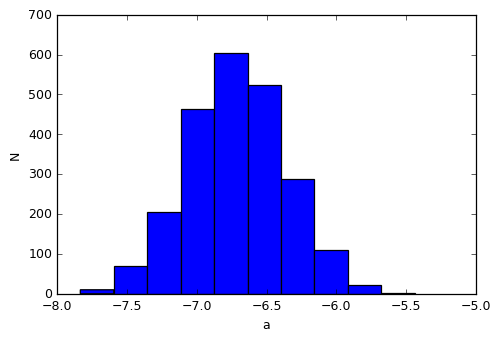

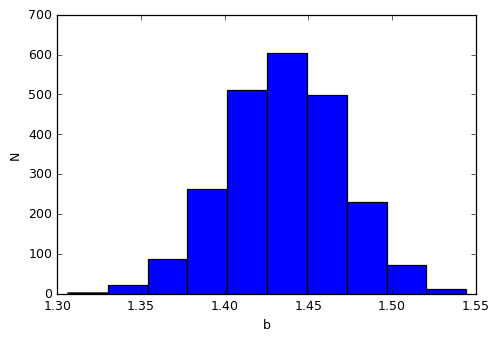

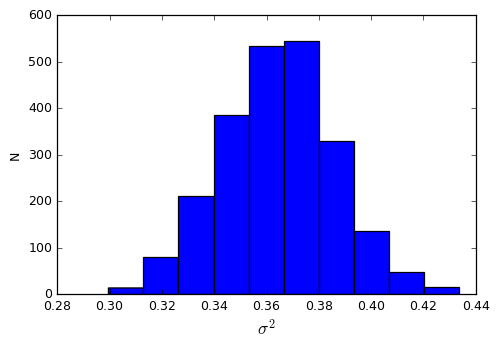

In [7]:
plt.xlabel('a')
plt.ylabel('N')
plt.hist(pboot[2])
plt.show()

plt.xlabel('b')
plt.ylabel('N')
plt.hist(pboot[0])
plt.show()

plt.xlabel('$\sigma^2$', size=14)
plt.ylabel('N')
plt.hist(pboot[1])
plt.show()

In [8]:
f = open('bootstrap.dat', 'w')
for bb, ss, aa in zip(pboot[0], pboot[1], pboot[2]):
    f.write('%.4f %.4f %.4f\n'%(bb, ss, aa))
f.close()

Let's now plot the range of models allowed by the best-fit parameters and their errors.

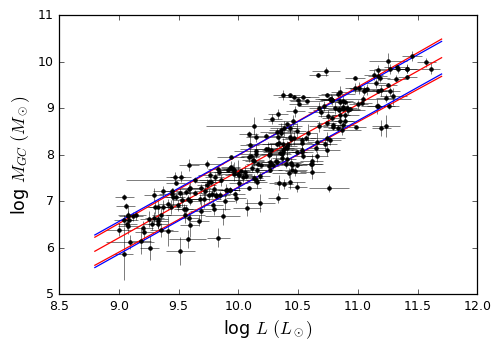

In [8]:
xa = np.linspace(8.8, 11.7)
plt.plot(xa, a + b*xa, 'r-')
plt.plot(xa, a + (b+pstd[0])*xa, 'r-')
plt.plot(xa, a + (b-pstd[0])*xa, 'r-')
plt.plot(xa, a+pstd[2] + b*xa, 'b-')
plt.plot(xa, a-pstd[2] + b*xa, 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

### Confidence limits

Bootstrap gives us the distributions of each of the model parameters.  We can use them to set confidence limits on the derived best-fit parameters.

<b>Exercise:</b> Write a routine to calculate the range containing a given percentage of the bootstrap distribution, for each of the model parameters.  For example, return $da$ such that 90% (should be free parameter) of the values of $a$ are within $a \pm da$.

Having bootstrap distributions also allows us to investigate the relations between the best-fit parameters.  For example, there is a strong anti-correlation of $a$ and $b$:

In [5]:
# new modules that will be needed here
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

# read saved bootstrap realization
bb, ss, aa = np.loadtxt("bootstrap.dat", unpack=True)

Boot: a = -6.7130 +- 0.3502  b = 1.4354 +- 0.0343  sig = 0.3645 +- 0.0216


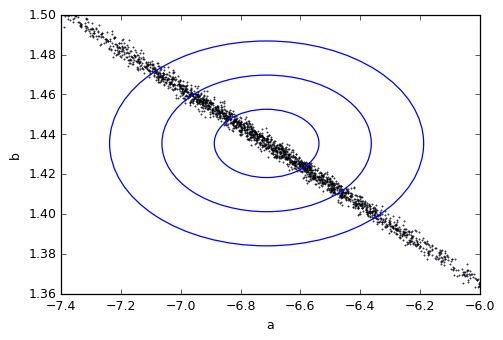

In [6]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean = [np.mean(aa), np.mean(bb)]
sigma1 = np.std(aa)
sigma2 = np.std(bb)

print 'Boot: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (np.mean(aa), np.std(aa), np.mean(bb), np.std(bb), np.mean(ss), np.std(ss))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

The blue contours enclose the expected $1\sigma$, $2\sigma$, and $3\sigma$ distribution of the parameters, in the absence of their correlation.  Clearly, they do not correspond to the actual distribution.

An alternative method, suggested by <a href="http://arxiv.org/abs/1008.4686">Hogg et al.</a>, effectively rotates the coordinate system to align with the correlation and fits the ellipses along and perpendicular to it.  The resulting contours are much tighter!

Corr: sigma1 = 0.3519  sigma2 = 0.0024  angle = -0.0973
Corr: a = -6.7130 +- 0.3500  b = 1.4354 +- 0.0365


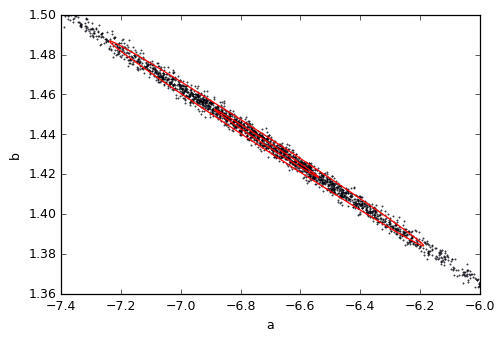

In [7]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean, sigma1, sigma2, alpha = fit_bivariate_normal(aa, bb, robust=False)

da = sigma1*np.cos(alpha) + sigma2*np.sin(alpha)
db = -sigma1*np.sin(alpha) + sigma2*np.cos(alpha)

print 'Corr: sigma1 = %.4f  sigma2 = %.4f  angle = %.4f' % (sigma1, sigma2, alpha)
print 'Corr: a = %.4f +- %.4f  b = %.4f +- %.4f' % (mean[0], da, mean[1], db)

for Nsig in (1, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

This method does not depend on whether we fit $x$ vs. $y$, or $y$ vs. $x$.  We will see below that it is a very useful property.  However, it has a potential pitfall in the interpretation of dispersions $\sigma_1$ and $\sigma_2$ when the variables $a$ and $b$ have different units.

There is another solution.  The correlation of $a$ and $b$ arises because the pivot point of our linear model (at $x=0$) is far from the actual range of data ($x>0$).  We can reduce it by choosing a different pivot point, somewhere in the middle of the distribution.  For example, the mean value of $x$.  This means we are re-defining our model as

$y = f(x | a,b,\sigma) = a + b (x-x_0) + \epsilon$.

The new intercept relates to the old one as $a_{new} = a_{old} + b x_0$. We should remember it when comparing results with the previous fit.

<b>Exercise:</b> Re-write the above functions <b>lnLikelihood</b> and <b>intercept</b> to include $x_0$.  Compare the 90% confidence limits of all model parameters with the case of $x_0=0$.  Check the correlation of $a$ and $b$.

In [8]:
def lnLikelihood0( p, xb, yb, dxb, dyb, x0 ):
    return lnLikelihood(p, xb-x0, yb, dxb, dyb)

def intercept0( p, xb, yb, dxb, dyb, x0 ):
    return intercept(p, xb-x0, yb, dxb, dyb)

In [9]:
x0 = np.mean(x)

pboot0 = [[], [], []]

for iboot in range(len(aa)):
    ir = np.random.randint(low=0, high=len(x), size=len(x))
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood0, [1.,1.], args=(xb, yb, dxb, dyb, x0))
    
    pboot0[0].append(o.x[0])
    pboot0[1].append(o.x[1])
    pboot0[2].append(intercept0(o.x, xb, yb, dxb, dyb, x0))
    
pboot0[2] -= x0*b

Boot: a = -6.7115 +- 0.0242  b = 1.4354 +- 0.0343  sig = 0.3645 +- 0.0216
x0 = 10.247  a = -6.7115 +- 0.0274  b = 1.4354 +- 0.0366


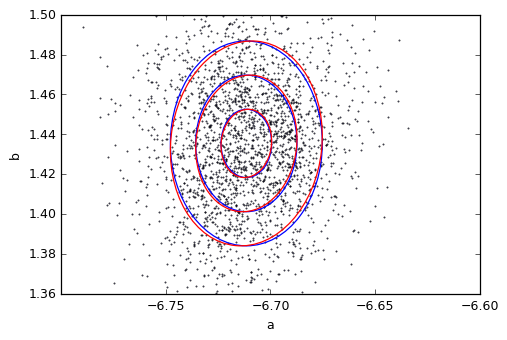

In [10]:
plt.xlim(-6.8, -6.6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(pboot0[2], pboot0[0], s=0.2)

# plot bootstrap distribution
mean = [np.mean(pboot0[2]), np.mean(pboot0[0])]
da = sigma1 = np.std(pboot0[2])
db = sigma2 = np.std(pboot0[0])

print 'Boot: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (np.mean(pboot0[2]), np.std(pboot0[2]), np.mean(pboot0[0]), np.std(pboot0[0]),\
   np.mean(pboot0[1]), np.std(pboot0[1]))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

# Hogg's method
mean, sigma1, sigma2, alpha = fit_bivariate_normal(pboot0[2], pboot0[0], robust=False)

da = abs(sigma1*np.cos(alpha) + sigma2*np.sin(alpha))
db = abs(sigma1*np.sin(alpha) + sigma2*np.cos(alpha))

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f' % (x0, mean[0], da, mean[1], db)

for Nsig in (1, 2, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

There is still some residual correlation of $a$ and $b$.  It can be minimized by a more sophisticated choice of the offset $x_0$.

Now let's plot the new fit and check that it still fits the original data. 

x0 = 10.247  a = -6.7106 +- 0.0274  b = 1.4353 +- 0.0366  sig2 = 0.3669 +- 0.0216


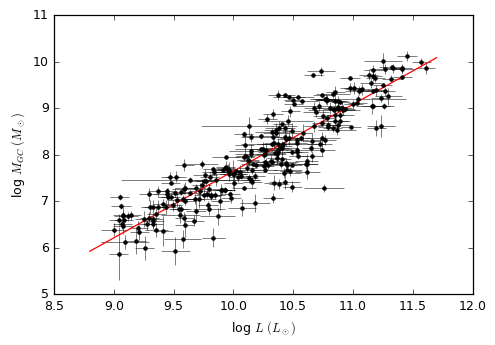

In [11]:
o = optimize.minimize(lnLikelihood0, [1.,1.], args=(x, y, dx, dy, x0))

a = intercept0(o.x, x, y, dx, dy, x0)
b = o.x[0]
sig2 = o.x[1]
sig = np.sqrt(sig2)
dsig = np.std(pboot0[1])

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f  sig2 = %.4f +- %.4f' %\
  (x0, a-b*x0, da, b, db, sig2, dsig)

xa = np.array([8.8, 11.7])
plt.plot(xa, a+b*(xa-x0), 'r-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

Finally, we can plot the best model including all parameter errors and the intrinsic scatter. This is the proper way to describe the model fit to the data.

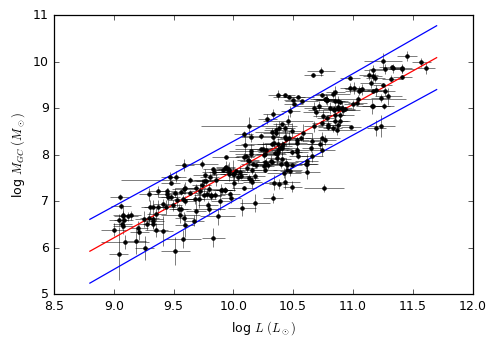

In [14]:
xa1 = np.array([8.8, x0])
plt.plot(xa1, a+b*(xa1-x0), 'r-')
plt.plot(xa1, a+(da+sig)+(b-db)*(xa1-x0), 'b-')
plt.plot(xa1, a-(da+sig)+(b+db)*(xa1-x0), 'b-')

xa2 = np.array([x0, 11.7])
plt.plot(xa2, a+b*(xa2-x0), 'r-')
plt.plot(xa2, a+(da+sig)+(b+db)*(xa2-x0), 'b-')
plt.plot(xa2, a-(da+sig)+(b-db)*(xa2-x0), 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

<b>Exercise:</b> Write a function that calculates bootstrapped estimate of $da$, with $x_0$ as an input argument. Find $x_0$ that minimizes $da$. Check the residual correlation of $a$ and $b$, and plot results.

### Forward fitting vs. Backward fitting

So far we have treated $x$ as an independent variable and $y$ as dependent variable, because we minimized the differences of $y_i$ from the model.  What if both variables are measured independently and we want to find the relation between them?  Do we get the same model if we fit $x$ vs. $y$?  For simplicity let's do it without the offsets.

$x = c + d \, y + \epsilon$

What are the expected values of $c$ and $d$ from our original fit parameters, $a$ and $b$?

In Homework 5 you evaluate the backward fit and compare it with the expected parameter values.

### Drawing from a distribution

It is often useful to be able to generate a simulated random sample drawn from a specified distribution.  This distribution may be analytical or discrete, such as an existing data sample.  A simulated sample can be used for comparison with data, in a technique called <i>parametric bootstrap</i>.

A general and very simple way to generate a univariate sample is the <b>transformation method</b>, described in $\S$7.3.2 of [Numerical Recipes](http://www.nr.com) or $\S$3.7 of [Machine Learning](http://www.astroml.org/).

[Figure 3.25](http://www.astroml.org/book_figures/chapter3/fig_clone_distribution.html) provides a good illustration. Here we have a data sample $x_i$. First we fill a corresponding array of the cumulative distribution function, $P(<x_i)$. Then we create an interpolating function, but in reverse, from $P(<x)$ to $x$. Then we draw a random number $r$ from 0 to 1 and use interpolation to find the value of $z$ corresponding to $P(<z) = r$. This procedure is repeated to accumulate the required size of the new sample $z_i$.

The example below shows how to clone a discrete sample, which we read from a data file.

KS test: D = 0.027; p = 1


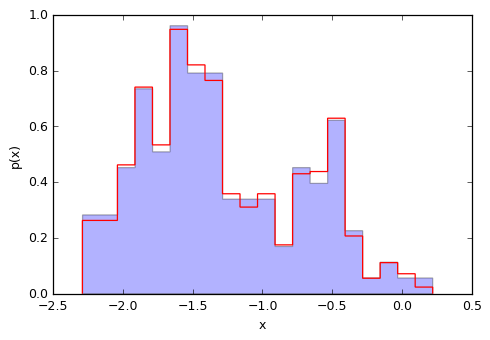

In [3]:
feh = np.loadtxt("gc.dat", usecols=(0,), unpack=True)

x = np.copy(feh)
x.sort()                        # sorted original sample
Px = np.linspace(0, 1, len(x))  # cumulative distribution of x

pspline = interpolate.UnivariateSpline(Px, x, s=0)  # create an interpolating function

Nsample = 1000                          # size of simulated sample
Px_sample = np.linspace(0, 1, Nsample)  # draw numbers between 0 and 1
x_sample = pspline(Px_sample)           # interpolate to build the simulated sample

D, p = stats.ks_2samp(x, x_sample)      # KS test to compare the simulated and original samples
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x, bins=20, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=20, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

The Kolmogorov-Smirnov test shows that the simulated sample is completely consistent with the original sample (the $p$-value is 100%, as high as it can be).

The transformation method can also be used to create a sample consistent with an analytical distribution function (DF). For example, let's generate a normal distribution from the analytical DF, and compare it with the NumPy's implementation.

First, we calculate and plot the cumulative DF.

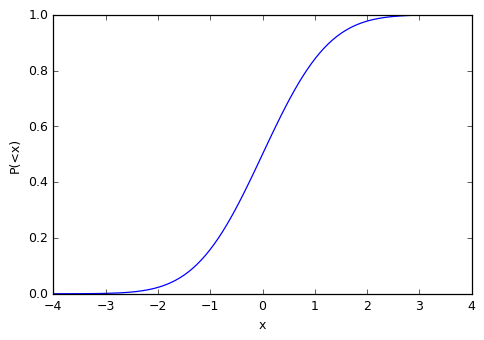

In [16]:
mu = 0.
sig = 1.

x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.

plt.plot(x, Px)
plt.xlabel('x', size=12)
plt.ylabel('P(<x)', size=12)
plt.show()

Now we create a simulated sample and compare it with the NumPy's implementation. The two are again completely consistent.

KS test: D = 0.026; p = 0.88


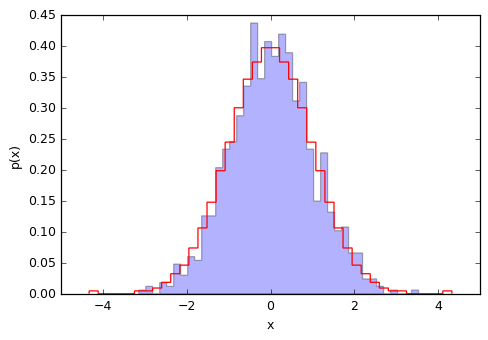

In [17]:
pspline = interpolate.UnivariateSpline(Px, x, s=0)  # create an interpolating function

Nsample = 1000
Px_sample = np.linspace(0, 1, Nsample)
x_sample = pspline(Px_sample)               # simulated sample

x_norm = np.random.normal(mu, sig, Nsample) # NumPy's implementation of a normal distribution

D, p = stats.ks_2samp(x_norm, x_sample)     # check consistency
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x_norm, bins=40, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=40, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

### Parametric bootstrap

The idea of parametric bootstrap is to test whether an observed data set is consistent with a specified distribution. We can always determine the best-fit parameters for a given model, but is the functional form of the model itself good enough to describe the data? 

For example, is our sample of globular cluster metallicities consistent with a normal distribution?

To answer this question, we need to:
1. Find a best-fitting normal distribution (calculate mean and standard deviation)
2. Calculate goodness of fit (for example, $\chi^2$ or another merit function)
3. Generate simulated samples corresponding to the best-fit model
4. Estimate the probability of the observed statistic in point 2 occuring in the parametric bootstrap samples. If this probability is small, we can reject the hypothesis that the data sample is drawn from the model distribution.

First, we calculate the mean and standard deviation of the observed [Fe/H] sample, and use them to construct the best-fit normal DF.

mean=-1.296 std=0.568 chi^2/dof=1.007


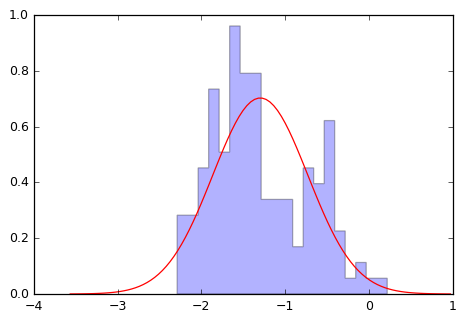

In [4]:
mu = np.mean(feh)
sig = np.std(feh, ddof=1)
chi2dof = np.sum(((feh-mu)/sig)**2)/(len(feh)-2)
print 'mean=%.3f std=%.3f chi^2/dof=%.3f'%(mu,sig,chi2dof)

plt.hist(feh, bins=20, normed=True, histtype='stepfilled', alpha=0.3)

x = np.linspace(mu-4*sig, mu+4*sig, 100)
plt.plot(x, 1./(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mu)/sig)**2/2), color='r')
plt.show()

Now run a fixed number of 1000 parametric bootstrap realizations.

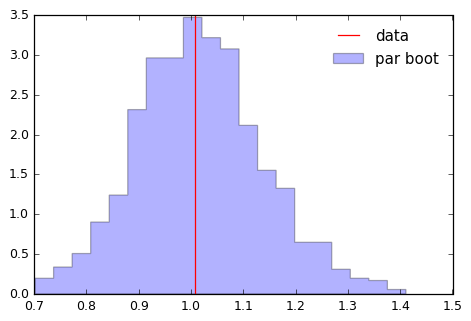

In [6]:
x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.
pspline = interpolate.UnivariateSpline(Px, x, s=0)

iboot = 0
chi2 = np.zeros(1000)
Nsample = len(feh)
while iboot < 1000:
    Px_sample = np.random.uniform(0, 1, Nsample)
    x_sample = pspline(Px_sample)
    chi2[iboot] = np.sum(((x_sample-mu)/sig)**2)/(len(x_sample)-2)
    iboot += 1

plt.hist(chi2, bins=20, normed=True, histtype='stepfilled', alpha=0.3, label='par boot')
plt.axvline(chi2dof, color='r', label='data')
plt.legend(frameon=False)
plt.show()

Finally, we need to calculate how likely the observed value of $\chi^2$ is to occur in this bootstrapped distribution.

In [7]:
z = np.sort(abs(chi2 - np.mean(chi2)))
zobs = abs(chi2dof - np.mean(chi2))
z_greaterthanobs = (z > zobs)
print 'probability of observed chi^2 =',np.sum(z_greaterthanobs)*1./len(z)

probability of observed chi^2 = 0.939


Our distribution has a 94% chance of being consistent with a normal distribution! This is a non-trivial result, given how different the histogram of the distribution looks.